In [ ]:
import numpy as np
import trimesh
from meshpy import triangle, geometry
import jax.numpy as jnp
from matplotlib.path import Path
from tqdm import tqdm
import sys
sys.path.append("..")
from src.mesher import *
from src.environment import *
from src.dynamics import *
from src.refiner import *

# Geometry Definition

In [ ]:
from_stl = False
from_bmp = True

## From STL

In [ ]:
if from_stl:
    # Load STL
    mesh = trimesh.load('Slice A_2D.stl')

    # Slice plane at Z=0
    plane_origin = [0, 0, 0]
    plane_normal = [0, 0, 1]

    # Get slice as Path3D
    slice_path = mesh.section(plane_origin=plane_origin, plane_normal=plane_normal)
    if slice_path is None:
        raise ValueError("No intersection at Z=0")

    # Get discrete points along the slice edges
    # slice_path.entities are line segments or polylines that define the slice
    edges = []
    geoms = []
    for entity in slice_path.entities:
        # Each entity has vertices indices pointing into slice_path.vertices
        verts_idx = entity.points
        # entity.points is Nx3 points in 3D, depending on entity type
        # For Line, get start and end points
        if len(verts_idx) > 10:
            # For example, get consecutive pairs of points as edges
            temp_edges = []
            for i in range(len(verts_idx)-1):
                p0 = verts_idx[i]
                p1 = verts_idx[i+1]
                edges.append([p0, p1])
                temp_edges.append([i, i+1])
            points = np.asarray(slice_path.vertices[verts_idx, :2])
            facets = np.asarray(temp_edges)
            holes = np.mean(points,axis=0)
            poly = points[facets[:,0]]
            path = Path(poly)
            if not path.contains_point(holes):
                print("adjusting hole at", holes)
                nearest_point = points[np.linalg.norm(points-holes, axis=1).argmin()]
                holes = nearest_point+.1 * (nearest_point - holes)
            
            geoms.append((points, facets, holes))

In [ ]:
if from_stl:
    points = slice_path.vertices[:, :2]
    facets = np.asarray(edges)

    plt.scatter(points[:, 0], points[:, 1])

    for edge in facets:
        p1, p2 = points[edge]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-')

    plt.gca().set_aspect('equal')
    plt.show()

## From BMP

In [ ]:
if from_bmp:
    from scipy.io import loadmat
    test = loadmat('test_bmp.mat')
    x = test["x"]
    y = test["y"]
    id = test["id"]
    holes = []
    for i in np.unique(id):
        mask = id == i
        x_i = x[mask]
        y_i = y[mask]
        holes.append(np.stack([x_i, y_i],axis=-1))


In [ ]:
if from_bmp:
    for hole in holes:
        plt.plot(hole[:, 0], hole[:, 1], 'r-')
    plt.show()

## Geometry Processing

In [ ]:
from shapely.geometry import Polygon
from shapely.ops import unary_union


# Define bounding box
bbox_points = [(-93, 0.), (186+93, 0.), (186+93, 186), (-93, 186)]
bounding_box = Polygon(bbox_points)

# Example: list of holes (make sure each is a list of (x,y) points)
if from_stl:
    holes = unary_union([Polygon(geom[0]) for geom in geoms])
elif from_bmp:
    holes = unary_union([Polygon(hole) for hole in holes])
    print("holes from bmp")

# Create polygon with holes
domain = Polygon(bbox_points)

domain_with_holes = domain.difference(holes)

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon,MultiPolygon
 
# Visualize the mesh boundary and holes
fig, ax = plt.subplots()
 
# Plot exterior boundary
if type(domain_with_holes) == MultiPolygon:
    domain_with_holes = domain_with_holes.geoms[0]

exterior = np.array(domain_with_holes.exterior.coords)
ax.plot(exterior[:,0], exterior[:,1], 'b.-', label='Boundary')
holes = domain_with_holes.interiors

for i, hole in enumerate(holes):
    hole_coords = np.array(hole.coords)
    ax.plot(hole_coords[:,0], hole_coords[:,1], 'r--', label=f'Hole {i+1}')

ax.set_aspect('equal')
plt.show()

## To Triangle

In [ ]:
builder = geometry.GeometryBuilder()

def get_facets(points):
    facets = np.asarray([(i,i+1) for i in range(len(points)-1)])
    facets[-1][1] = 0
    return np.asarray(points),facets

def custom_box_markers(points,facets,markers=[1,2,3,4]):
    corners = np.stack([np.max(points,axis=0),np.min(points,axis=0)])
    corner_points = np.concatenate([np.where(points[:-1,0] == corners[0,0])[0],np.where(points[:-1,0] == corners[1,0])[0]])
    i=-1
    facet_markers = []
    for facet in facets:
        if facet[0] in corner_points:
            i += 1
        facet_markers.append(markers[i])
    return facet_markers

points,facets = get_facets(domain_with_holes.exterior.coords)
facet_markers = custom_box_markers(points, facets)

builder.add_geometry(points,facets,facet_markers=facet_markers)
holes = []
for points in domain_with_holes.interiors:
    points,facets = get_facets(points.coords)
    builder.add_geometry(points,facets,facet_markers=5)
    temp_holes = np.mean(points,axis=0)
    poly = points
    path = Path(poly)
    if not path.contains_point(temp_holes):
        print("adjusting hole at", temp_holes)
        nearest_point = points[np.linalg.norm(points-temp_holes, axis=1).argmin()]
        temp_holes = nearest_point+.1 * (nearest_point - temp_holes)
    holes.append(temp_holes)

In [ ]:
for facet, marker in zip(builder.facets, builder.facet_markers):
    match marker:
        case 1:
            color = 'blue'
        case 2:
            color = 'green'
        case 3:
            color = 'orange'
        case 4:
            color = 'purple'
        case 5:
            color = "black"
    plt.plot(np.asarray(builder.points)[facet, 0], np.asarray(builder.points)[facet, 1], color=color, linewidth=0.5)
    #plt.text(np.mean(np.asarray(builder.points)[facet, 0]), np.mean(np.asarray(builder.points)[facet, 1]), str(marker), fontsize=8, ha='center')
plt.axis('equal')
plt.show()

In [ ]:
for facet in builder.facets:
    plt.plot(np.asarray(builder.points)[facet, 0], np.asarray(builder.points)[facet, 1], color="r", linewidth=0.5)
plt.scatter(np.asarray(holes)[:, 0], np.asarray(holes)[:, 1], color="b", s=10, label="Holes")
plt.axis('equal')
plt.show()

## Meshing

In [ ]:
info = triangle.MeshInfo()
builder.set(info)
info.set_holes(np.asarray(holes))

In [ ]:
mesh = triangle.build(info,
                      max_volume=.3,
                      min_angle=30.0, 
                      generate_faces=True,
                      volume_constraints=True)
#print(np.array(mesh.points).shape[0])

In [ ]:
print(np.array(mesh.points).shape[0])

In [ ]:
improver = MeshRefiner(mesh,np.asarray(holes))
improver.show_mesh_quality()
mesh = improver.improve(aspect_thresh=3.0,
                        skew_thresh=30.0,
                        max_volume=0.00001,
                        move_fraction=.25,
                        max_iter=10)
improver.show_mesh_quality()

In [ ]:
mesh_points = np.array(mesh.points)
mesh_tris = np.array(mesh.elements)
mesh_attr = np.array(mesh.point_markers)

for i,marker in enumerate(mesh_attr):
    if marker != 0:
        match marker:
            case 1:
                color = 'blue'
            case 2:
                color = 'green'
            case 3:
                color = 'orange'
            case 4:
                color = 'purple'
            case 5:
                color = "black"
            case _:
                color = "white"
        
        plt.plot(mesh_points[i,0],mesh_points[i,1],color=color, marker='.')

plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
#plt.axis([0,.1,0,.1])
plt.show()

# Mesh Pre-Processing

In [ ]:
mesher = Mesher()
mesher.import_meshpy(mesh)
mesher.calc_mesh_properties()
mesher.verify_stencil_geometry()

# Env Definitiion

In [63]:
Tau = 0.65
dt = .1            # time step *** run 1 mill steps
rho_in = 1.05      # inlet density
rho_out = .95          # outlet density

dynamics = D2Q9(tau=Tau,delta_t = dt)

In [64]:
cells,faces,nodes = mesher.to_env(dynamics,flux_method="lax_wendroff")
nodes = mesher.set_vel_node(nodes,marker=5,velocity=np.asarray((0,0)))
nodes = mesher.set_vel_node(nodes,marker=2,velocity=np.asarray((0,0)))
nodes = mesher.set_vel_node(nodes,marker=4,velocity=np.asarray((0,0)))
nodes = mesher.set_rho_node(nodes,marker=1,rho=rho_in)
nodes = mesher.set_rho_node(nodes,marker=3,rho=rho_out)

/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src/mesher.py:649: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  faces.n = jnp.array(self.face_normals,dtype=jnp.float64)
/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src/mesher.py:650: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  faces.L = jnp.array(self.face_lengths,dtype=jnp.float64)[...,jnp.newaxis] * dim_multiplier
/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/.

In [65]:
env = Environment(cells,faces,nodes)
env.init()

Temp Save

In [66]:
mesher.to_pickle(env,'porous_temp')

# Simulation

In [ ]:
for i in tqdm(range(1000000)):
    env = env.step()

# Post Processing

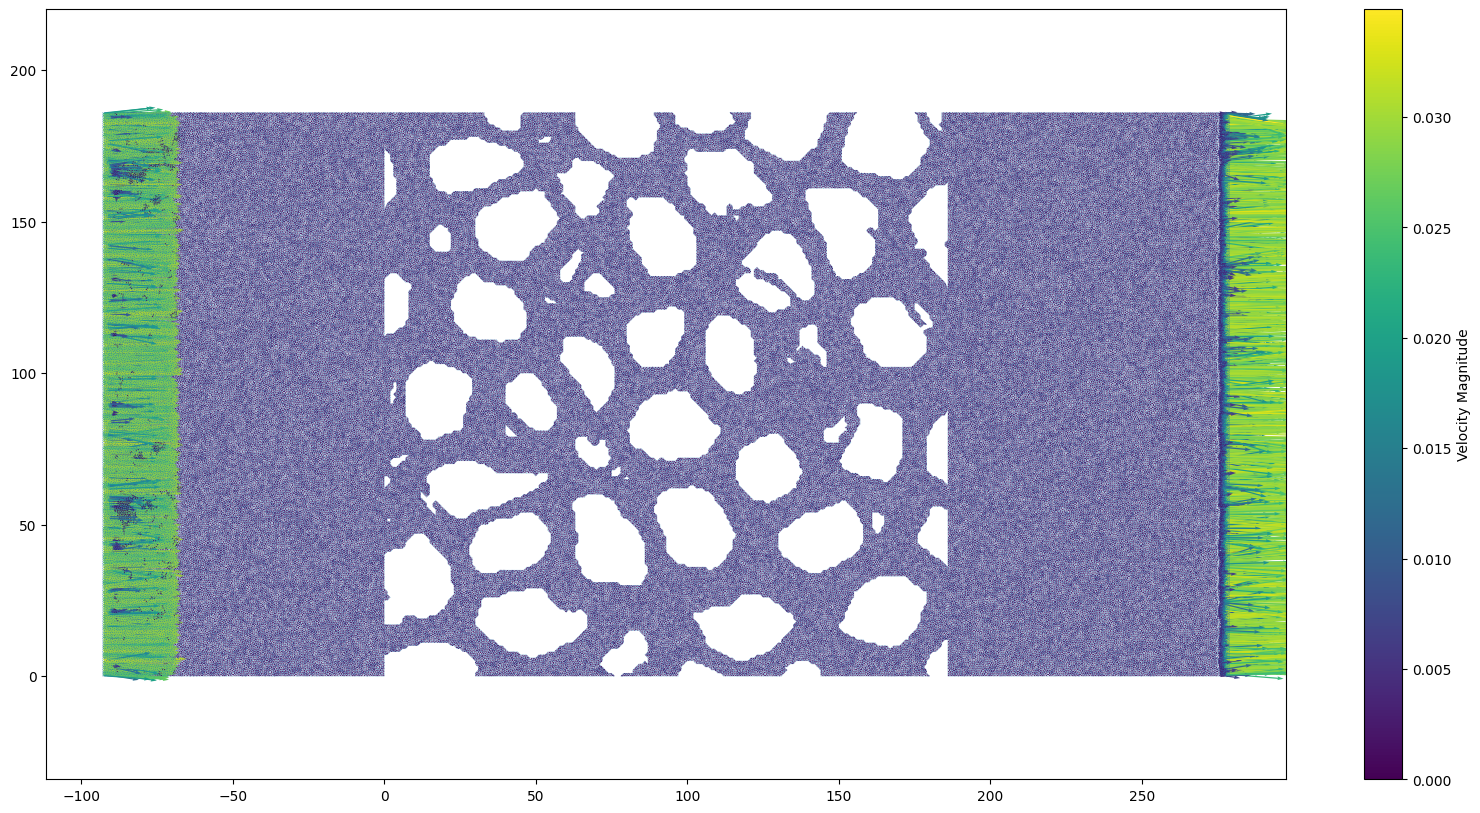

In [60]:
xy = np.array(mesher.cell_centers)
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel 
mag = np.sqrt(np.sum(vel**2,axis=-1))
fig = plt.figure(figsize=(20,10))
plt.quiver(x,y,vel[:,0],vel[:,1],mag,scale=.5,headlength=5,headwidth=3,width=.001)
xy = np.asarray(mesher.points)
x = xy[:,0]
y = xy[:,1]
tri = np.asarray(mesher.cells)
import matplotlib.tri as mtri
triangles = mtri.Triangulation(x, y, tri)
plt.triplot(triangles, linewidth=0.1)
plt.axis("equal")
plt.colorbar(label="Velocity Magnitude")
plt.show()

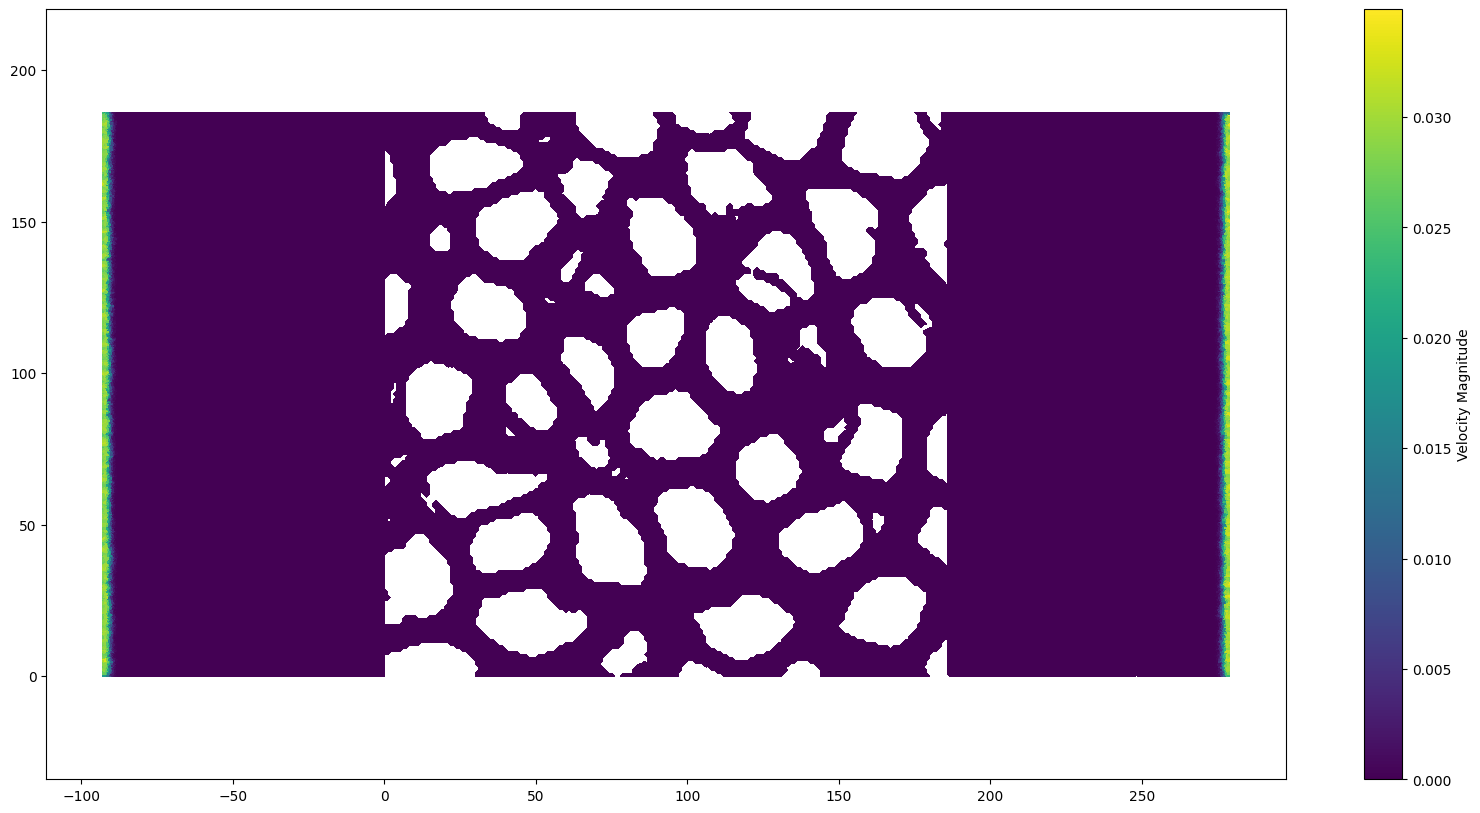

In [61]:
vel = env.cells.vel
mag = np.sqrt(np.sum(vel**2,axis=-1))
fig = plt.figure(figsize=(20,10))
plt.tripcolor(triangles, mag, cmap='viridis', vmin=jnp.min(mag), vmax=jnp.max(mag))
plt.axis('equal')
#plt.xlim(0,.3)
plt.colorbar(label="Velocity Magnitude")
plt.show()

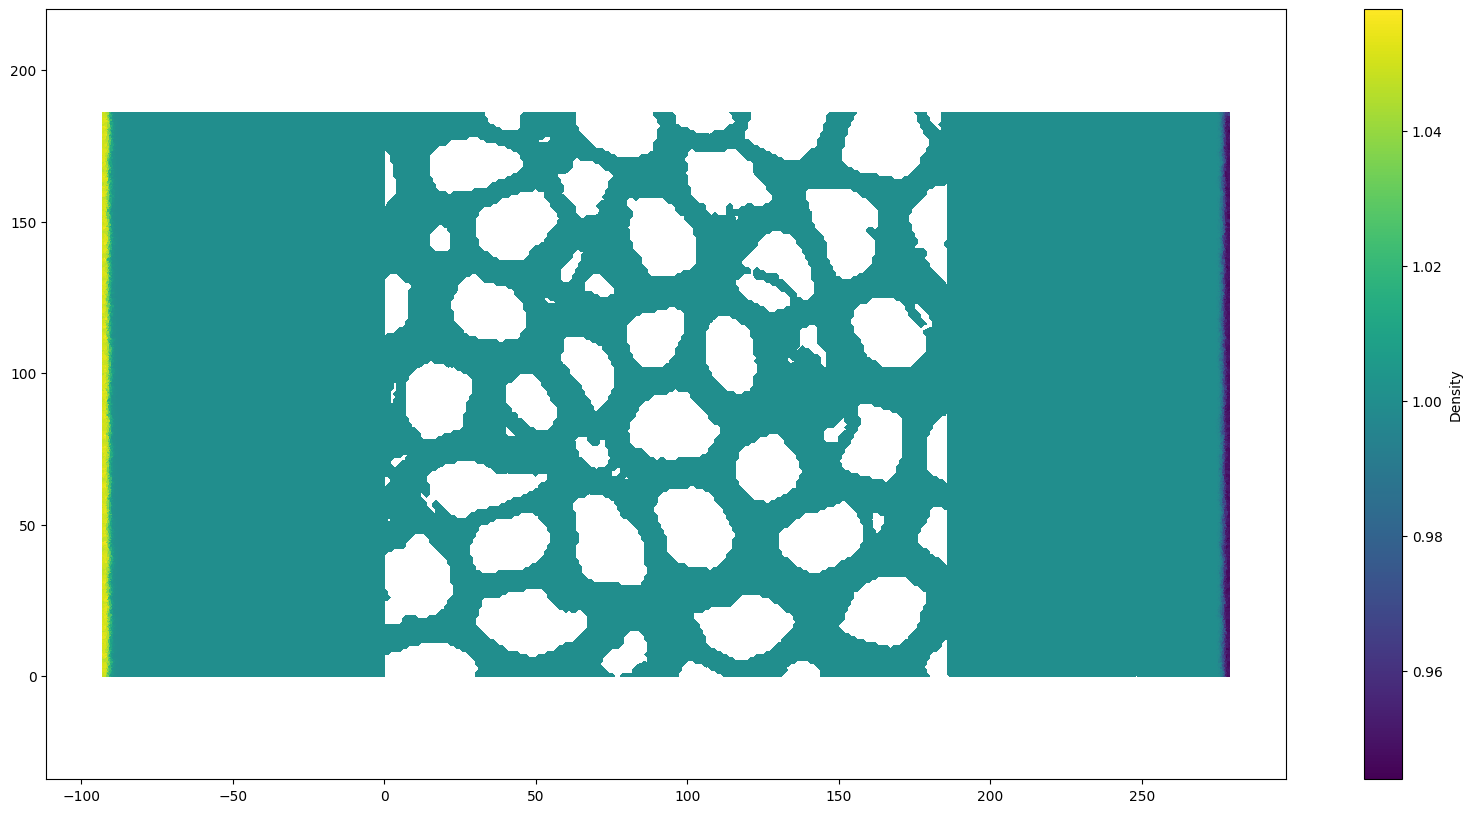

In [62]:
rho = env.cells.rho[:,0]
fig = plt.figure(figsize=(20,10))
plt.tripcolor(triangles, rho, cmap='viridis', vmin=jnp.min(rho), vmax=jnp.max(rho))
plt.axis('equal')
#plt.xlim(0,.3)
plt.colorbar(label="Density")
plt.show()

In [ ]:
mesher.to_vtk(env,'porous_flow')
mesher.to_pickle(env,'porous_flow')

# Load from save

In [ ]:
env,mesher = Mesher.from_pickle('porous_flow')